# Method 3 - Best Ideas Low Liquidity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Get Liquidity

distinct_ideas = best_ideas[['datadate', 'fsym_id']].drop_duplicates()
distinct_ideas['in'] = 1

bid_asks = crsp.get_crsp_fsym_bid_ask(list(set(distinct_ideas['fsym_id'].dropna())),
                                      distinct_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
bid_asks['rel_bid_ask'] = (bid_asks['ask'] - bid_asks['bid']) / ((bid_asks['bid'] + bid_asks['ask']) / 2)
bid_asks['datadate'] = bid_asks['datadate'] + pd.offsets.QuarterEnd(0)
qe_bid_asks = bid_asks.groupby(['datadate', 'fsym_id'])['rel_bid_ask'].mean().reset_index()
qe_bid_asks = qe_bid_asks.merge(distinct_ideas)

qe_bid_asks['median_bid_ask'] = qe_bid_asks.groupby('datadate')['rel_bid_ask'].transform('median')
qe_bid_asks = qe_bid_asks[qe_bid_asks['rel_bid_ask'] > qe_bid_asks['median_bid_ask']]

best_ideas = best_ideas.merge(qe_bid_asks)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

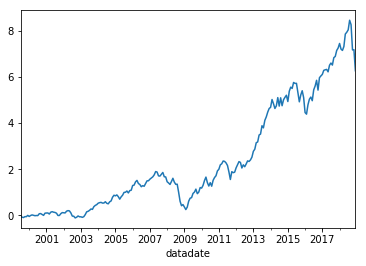

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.000465
2000-12-31    0.096292
2001-12-31    0.022259
2002-12-31   -0.161606
2003-12-31    0.560079
2004-12-31    0.277803
2005-12-31    0.115403
2006-12-31    0.196292
2007-12-31    0.066575
2008-12-31   -0.449234
2009-12-31    0.501967
2010-12-31    0.327489
2011-12-31   -0.018476
2012-12-31    0.225846
2013-12-31    0.598573
2014-12-31    0.102097
2015-12-31   -0.016663
2016-12-31    0.153931
2017-12-31    0.171863
2018-12-31   -0.119257
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     352.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.55e-96
Time:                        13:27:34   Log-Likelihood:                 583.76
No. Observations:                 234   AIC:                            -1158.
Df Residuals:                     229   BIC:                            -1140.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.054      0.041       0.000       0.006
mktrf          1.0753      0.038     28.564      0.000       1.001       1.149
me             0.4388      0.044     10.021      0.000       0.353       0.525
ia             0.3610      0.067      5.424      0.000       0.230       0.492
roe            0.1082      0.057      1.898      0.059      -0.004       0.220
==============================================================================
Omnibus:                       13.113   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.875
Skew:                          -0.397   Prob(JB):                     0.000131
Kurtosis:                       4.097   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     599.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.45e-120
Time:                        13:27:34   Log-Likelihood:                 583.76
No. Observations:                 234   AIC:                            -1158.
Df Residuals:                     229   BIC:                            -1140.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.154      0.031       0.000       0.005
mktrf          1.0753      0.040     27.057      0.000       0.997       1.153
me             0.4388      0.114      3.843      0.000       0.215       0.663
ia             0.3610      0.147      2.462      0.014       0.074       0.648
roe            0.1082      0.074      1.471      0.141      -0.036       0.252
==============================================================================
Omnibus:                       13.113   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.875
Skew:                          -0.397   Prob(JB):                     0.000131
Kurtosis:                       4.097   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1054.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.73e-146
Time:                        13:27:34   Log-Likelihood:                 583.76
No. Observations:                 234   AIC:                            -1158.
Df Residuals:                     229   BIC:                            -1140.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.450      0.014       0.001       0.005
mktrf          1.0753      0.038     28.260      0.000       1.001       1.150
me             0.4388      0.113      3.872      0.000       0.217       0.661
ia             0.3610      0.176      2.046      0.041       0.015       0.707
roe            0.1082      0.082      1.324      0.186      -0.052       0.268
==============================================================================
Omnibus:                       13.113   Durbin-Watson:                   1.779
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.875
Skew:                          -0.397   Prob(JB):                     0.000131
Kurtosis:                       4.097   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     292.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.08e-97
Time:                        13:27:34   Log-Likelihood:                 587.99
No. Observations:                 234   AIC:                            -1164.
Df Residuals:                     228   BIC:                            -1143.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.709      0.089      -0.000       0.005
mktrf          1.0771      0.037     29.012      0.000       1.004       1.150
smb            0.5138      0.049     10.489      0.000       0.417       0.610
hml            0.1833      0.058      3.173      0.002       0.069       0.297
rmw            0.1953      0.065      2.991      0.003       0.067       0.324
cma            0.1228      0.083      1.479      0.141      -0.041       0.286
==============================================================================
Omnibus:                       14.637   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.596
Skew:                          -0.426   Prob(JB):                     3.37e-05
Kurtosis:                       4.177   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     410.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.84e-112
Time:                        13:27:34   Log-Likelihood:                 587.99
No. Observations:                 234   AIC:                            -1164.
Df Residuals:                     228   BIC:                            -1143.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.724      0.085      -0.000       0.005
mktrf          1.0771      0.039     27.355      0.000       1.000       1.154
smb            0.5138      0.088      5.830      0.000       0.341       0.687
hml            0.1833      0.125      1.470      0.142      -0.061       0.428
rmw            0.1953      0.070      2.782      0.005       0.058       0.333
cma            0.1228      0.123      0.997      0.319      -0.119       0.364
==============================================================================
Omnibus:                       14.637   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.596
Skew:                          -0.426   Prob(JB):                     3.37e-05
Kurtosis:                       4.177   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     646.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.88e-132
Time:                        13:27:34   Log-Likelihood:                 587.99
No. Observations:                 234   AIC:                            -1164.
Df Residuals:                     228   BIC:                            -1143.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.895      0.058   -8.02e-05       0.005
mktrf          1.0771      0.037     28.780      0.000       1.004       1.150
smb            0.5138      0.098      5.237      0.000       0.322       0.706
hml            0.1833      0.135      1.357      0.175      -0.082       0.448
rmw            0.1953      0.074      2.645      0.008       0.051       0.340
cma            0.1228      0.125      0.981      0.326      -0.122       0.368
==============================================================================
Omnibus:                       14.637   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.596
Skew:                          -0.426   Prob(JB):                     3.37e-05
Kurtosis:                       4.177   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     326.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.70e-93
Time:                        13:27:34   Log-Likelihood:                 576.13
No. Observations:                 234   AIC:                            -1142.
Df Residuals:                     229   BIC:                            -1125.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      2.543      0.012       0.001       0.006
mktrf          1.0410      0.036     29.071      0.000       0.970       1.112
smb            0.3871      0.045      8.659      0.000       0.299       0.475
hml            0.3933      0.044      8.857      0.000       0.306       0.481
umd            0.0478      0.029      1.641      0.102      -0.010       0.105
==============================================================================
Omnibus:                       16.292   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.151
Skew:                          -0.390   Prob(JB):                     7.71e-07
Kurtosis:                       4.509   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     369.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.33e-98
Time:                        13:27:34   Log-Likelihood:                 576.13
No. Observations:                 234   AIC:                            -1142.
Df Residuals:                     229   BIC:                            -1125.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      2.566      0.010       0.001       0.006
mktrf          1.0410      0.043     24.179      0.000       0.957       1.125
smb            0.3871      0.099      3.906      0.000       0.193       0.581
hml            0.3933      0.118      3.344      0.001       0.163       0.624
umd            0.0478      0.062      0.773      0.439      -0.073       0.169
==============================================================================
Omnibus:                       16.292   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.151
Skew:                          -0.390   Prob(JB):                     7.71e-07
Kurtosis:                       4.509   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     471.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.78e-109
Time:                        13:27:34   Log-Likelihood:                 576.13
No. Observations:                 234   AIC:                            -1142.
Df Residuals:                     229   BIC:                            -1125.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.097      0.002       0.001       0.006
mktrf          1.0410      0.038     27.634      0.000       0.967       1.115
smb            0.3871      0.109      3.545      0.000       0.173       0.601
hml            0.3933      0.137      2.875      0.004       0.125       0.661
umd            0.0478      0.052      0.913      0.361      -0.055       0.150
==============================================================================
Omnibus:                       16.292   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.151
Skew:                          -0.390   Prob(JB):                     7.71e-07
Kurtosis:                       4.509   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     172.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.39e-47
Time:                        13:27:34   Log-Likelihood:                 293.48
No. Observations:                 120   AIC:                            -577.0
Df Residuals:                     115   BIC:                            -563.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.639      0.104      -0.001       0.007
mktrf          1.1332      0.055     20.523      0.000       1.024       1.243
me             0.3360      0.055      6.161      0.000       0.228       0.444
ia             0.4693      0.085      5.496      0.000       0.300       0.638
roe            0.2060      0.076      2.726      0.007       0.056       0.356
==============================================================================
Omnibus:                        1.420   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.492   Jarque-Bera (JB):                0.943
Skew:                          -0.156   Prob(JB):                        0.624
Kurtosis:                       3.301   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     228.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-53
Time:                        13:27:34   Log-Likelihood:                 293.48
No. Observations:                 120   AIC:                            -577.0
Df Residuals:                     115   BIC:                            -563.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.696      0.090      -0.001       0.007
mktrf          1.1332      0.049     22.916      0.000       1.036       1.230
me             0.3360      0.086      3.907      0.000       0.167       0.505
ia             0.4693      0.135      3.473      0.001       0.205       0.734
roe            0.2060      0.078      2.655      0.008       0.054       0.358
==============================================================================
Omnibus:                        1.420   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.492   Jarque-Bera (JB):                0.943
Skew:                          -0.156   Prob(JB):                        0.624
Kurtosis:                       3.301   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     359.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.78e-64
Time:                        13:27:34   Log-Likelihood:                 293.48
No. Observations:                 120   AIC:                            -577.0
Df Residuals:                     115   BIC:                            -563.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.058      0.040       0.000       0.007
mktrf          1.1332      0.043     26.127      0.000       1.048       1.218
me             0.3360      0.087      3.868      0.000       0.166       0.506
ia             0.4693      0.153      3.071      0.002       0.170       0.769
roe            0.2060      0.070      2.939      0.003       0.069       0.343
==============================================================================
Omnibus:                        1.420   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.492   Jarque-Bera (JB):                0.943
Skew:                          -0.156   Prob(JB):                        0.624
Kurtosis:                       3.301   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     131.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-45
Time:                        13:27:34   Log-Likelihood:                 291.58
No. Observations:                 120   AIC:                            -571.2
Df Residuals:                     114   BIC:                            -554.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.356      0.178      -0.001       0.007
mktrf          1.1422      0.059     19.224      0.000       1.024       1.260
smb            0.4208      0.067      6.253      0.000       0.287       0.554
hml            0.1299      0.082      1.576      0.118      -0.033       0.293
rmw            0.2792      0.097      2.872      0.005       0.087       0.472
cma            0.2758      0.107      2.589      0.011       0.065       0.487
==============================================================================
Omnibus:                        4.962   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.410
Skew:                          -0.393   Prob(JB):                        0.110
Kurtosis:                       3.513   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     196.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.35e-54
Time:                        13:27:34   Log-Likelihood:                 291.58
No. Observations:                 120   AIC:                            -571.2
Df Residuals:                     114   BIC:                            -554.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.436      0.151      -0.001       0.007
mktrf          1.1422      0.077     14.887      0.000       0.992       1.293
smb            0.4208      0.093      4.501      0.000       0.238       0.604
hml            0.1299      0.181      0.720      0.472      -0.224       0.484
rmw            0.2792      0.151      1.844      0.065      -0.018       0.576
cma            0.2758      0.125      2.203      0.028       0.030       0.521
==============================================================================
Omnibus:                        4.962   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.410
Skew:                          -0.393   Prob(JB):                        0.110
Kurtosis:                       3.513   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     347.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.20e-67
Time:                        13:27:34   Log-Likelihood:                 291.58
No. Observations:                 120   AIC:                            -571.2
Df Residuals:                     114   BIC:                            -554.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.001      1.973      0.048    1.98e-05       0.006
mktrf          1.1422      0.082     13.927      0.000       0.981       1.303
smb            0.4208      0.107      3.938      0.000       0.211       0.630
hml            0.1299      0.203      0.639      0.523      -0.269       0.528
rmw            0.2792      0.175      1.594      0.111      -0.064       0.623
cma            0.2758      0.119      2.308      0.021       0.042       0.510
==============================================================================
Omnibus:                        4.962   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.410
Skew:                          -0.393   Prob(JB):                        0.110
Kurtosis:                       3.513   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     140.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.31e-43
Time:                        13:27:34   Log-Likelihood:                 283.31
No. Observations:                 120   AIC:                            -556.6
Df Residuals:                     115   BIC:                            -542.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.002      2.377      0.019       0.001       0.010
mktrf          1.0379      0.053     19.603      0.000       0.933       1.143
smb            0.2759      0.060      4.577      0.000       0.156       0.395
hml            0.4341      0.060      7.189      0.000       0.314       0.554
umd            0.0504      0.037      1.355      0.178      -0.023       0.124
==============================================================================
Omnibus:                        9.461   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               14.428
Skew:                          -0.359   Prob(JB):                     0.000736
Kurtosis:                       4.540   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     212.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.04e-52
Time:                        13:27:34   Log-Likelihood:                 283.31
No. Observations:                 120   AIC:                            -556.6
Df Residuals:                     115   BIC:                            -542.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.002      2.549      0.011       0.001       0.009
mktrf          1.0379      0.070     14.775      0.000       0.900       1.176
smb            0.2759      0.077      3.577      0.000       0.125       0.427
hml            0.4341      0.136      3.188      0.001       0.167       0.701
umd            0.0504      0.070      0.722      0.470      -0.086       0.187
==============================================================================
Omnibus:                        9.461   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               14.428
Skew:                          -0.359   Prob(JB):                     0.000736
Kurtosis:                       4.540   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     336.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.72e-62
Time:                        13:27:34   Log-Likelihood:                 283.31
No. Observations:                 120   AIC:                            -556.6
Df Residuals:                     115   BIC:                            -542.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.002      3.252      0.001       0.002       0.008
mktrf          1.0379      0.060     17.227      0.000       0.920       1.156
smb            0.2759      0.081      3.411      0.001       0.117       0.434
hml            0.4341      0.152      2.851      0.004       0.136       0.732
umd            0.0504      0.056      0.894      0.371      -0.060       0.161
==============================================================================
Omnibus:                        9.461   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               14.428
Skew:                          -0.359   Prob(JB):                     0.000736
Kurtosis:                       4.540   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     530.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.95e-70
Time:                        13:27:34   Log-Likelihood:                 349.87
No. Observations:                 114   AIC:                            -689.7
Df Residuals:                     109   BIC:                            -676.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      3.692      0.000       0.002       0.006
mktrf          0.9670      0.034     28.604      0.000       0.900       1.034
me             0.7509      0.052     14.387      0.000       0.647       0.854
ia            -0.1523      0.072     -2.103      0.038      -0.296      -0.009
roe           -0.3457      0.064     -5.434      0.000      -0.472      -0.220
==============================================================================
Omnibus:                        0.559   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.569
Skew:                           0.163   Prob(JB):                        0.752
Kurtosis:                       2.884   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1120.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.64e-87
Time:                        13:27:34   Log-Likelihood:                 349.87
No. Observations:                 114   AIC:                            -689.7
Df Residuals:                     109   BIC:                            -676.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      3.470      0.001       0.002       0.007
mktrf          0.9670      0.029     33.692      0.000       0.911       1.023
me             0.7509      0.048     15.773      0.000       0.658       0.844
ia            -0.1523      0.077     -1.976      0.048      -0.303      -0.001
roe           -0.3457      0.074     -4.651      0.000      -0.491      -0.200
==============================================================================
Omnibus:                        0.559   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.569
Skew:                           0.163   Prob(JB):                        0.752
Kurtosis:                       2.884   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1979.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.58e-101
Time:                        13:27:34   Log-Likelihood:                 349.87
No. Observations:                 114   AIC:                            -689.7
Df Residuals:                     109   BIC:                            -676.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.001      3.010      0.003       0.001       0.007
mktrf          0.9670      0.025     38.512      0.000       0.918       1.016
me             0.7509      0.046     16.272      0.000       0.660       0.841
ia            -0.1523      0.086     -1.765      0.078      -0.321       0.017
roe           -0.3457      0.064     -5.409      0.000      -0.471      -0.220
==============================================================================
Omnibus:                        0.559   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.569
Skew:                           0.163   Prob(JB):                        0.752
Kurtosis:                       2.884   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     519.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.90e-74
Time:                        13:27:34   Log-Likelihood:                 361.38
No. Observations:                 114   AIC:                            -710.8
Df Residuals:                     108   BIC:                            -694.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.988      0.003       0.001       0.005
mktrf          1.0002      0.029     34.161      0.000       0.942       1.058
smb            0.7196      0.048     15.138      0.000       0.625       0.814
hml           -0.0341      0.061     -0.563      0.575      -0.154       0.086
rmw           -0.4741      0.074     -6.387      0.000      -0.621      -0.327
cma           -0.1254      0.094     -1.331      0.186      -0.312       0.061
==============================================================================
Omnibus:                        0.236   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.414
Skew:                           0.001   Prob(JB):                        0.813
Kurtosis:                       2.705   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     657.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.18e-79
Time:                        13:27:34   Log-Likelihood:                 361.38
No. Observations:                 114   AIC:                            -710.8
Df Residuals:                     108   BIC:                            -694.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.685      0.007       0.001       0.005
mktrf          1.0002      0.020     49.792      0.000       0.961       1.040
smb            0.7196      0.057     12.709      0.000       0.609       0.831
hml           -0.0341      0.048     -0.707      0.480      -0.129       0.061
rmw           -0.4741      0.064     -7.413      0.000      -0.599      -0.349
cma           -0.1254      0.081     -1.557      0.119      -0.283       0.032
==============================================================================
Omnibus:                        0.236   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.414
Skew:                           0.001   Prob(JB):                        0.813
Kurtosis:                       2.705   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     817.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.57e-84
Time:                        13:27:34   Log-Likelihood:                 361.38
No. Observations:                 114   AIC:                            -710.8
Df Residuals:                     108   BIC:                            -694.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.293      0.022       0.000       0.006
mktrf          1.0002      0.021     48.103      0.000       0.959       1.041
smb            0.7196      0.055     12.968      0.000       0.611       0.828
hml           -0.0341      0.044     -0.776      0.438      -0.120       0.052
rmw           -0.4741      0.064     -7.355      0.000      -0.600      -0.348
cma           -0.1254      0.075     -1.672      0.095      -0.273       0.022
==============================================================================
Omnibus:                        0.236   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.414
Skew:                           0.001   Prob(JB):                        0.813
Kurtosis:                       2.705   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     446.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.38e-66
Time:                        13:27:35   Log-Likelihood:                 340.58
No. Observations:                 114   AIC:                            -671.2
Df Residuals:                     109   BIC:                            -657.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.498      0.137      -0.001       0.004
mktrf          1.0443      0.035     30.049      0.000       0.975       1.113
smb            0.8214      0.054     15.158      0.000       0.714       0.929
hml            0.0492      0.056      0.881      0.380      -0.061       0.160
umd            0.0137      0.042      0.326      0.745      -0.070       0.097
==============================================================================
Omnibus:                        0.095   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.954   Jarque-Bera (JB):                0.001
Skew:                          -0.008   Prob(JB):                        0.999
Kurtosis:                       3.001   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     612.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.03e-73
Time:                        13:27:35   Log-Likelihood:                 340.58
No. Observations:                 114   AIC:                            -671.2
Df Residuals:                     109   BIC:                            -657.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.385      0.166      -0.001       0.004
mktrf          1.0443      0.028     36.981      0.000       0.989       1.100
smb            0.8214      0.063     12.993      0.000       0.697       0.945
hml            0.0492      0.058      0.849      0.396      -0.064       0.163
umd            0.0137      0.036      0.383      0.702      -0.057       0.084
==============================================================================
Omnibus:                        0.095   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.954   Jarque-Bera (JB):                0.001
Skew:                          -0.008   Prob(JB):                        0.999
Kurtosis:                       3.001   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     731.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-77
Time:                        13:27:35   Log-Likelihood:                 340.58
No. Observations:                 114   AIC:                            -671.2
Df Residuals:                     109   BIC:                            -657.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.268      0.205      -0.001       0.005
mktrf          1.0443      0.028     37.801      0.000       0.990       1.098
smb            0.8214      0.056     14.630      0.000       0.711       0.931
hml            0.0492      0.057      0.862      0.389      -0.063       0.161
umd            0.0137      0.030      0.462      0.644      -0.044       0.072
==============================================================================
Omnibus:                        0.095   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.954   Jarque-Bera (JB):                0.001
Skew:                          -0.008   Prob(JB):                        0.999
Kurtosis:                       3.001   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""